## Clasificacion de señales
- Wifi y LTE
- pytorch


In [2]:
#Listo las carpetas que contiene el dataset
!ls '/home/fpineda/dataset/teleco_signal/'

test  train  val


In [3]:
#Verifico la capacidad de GPU
!nvidia-smi

Thu Jul 20 16:58:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   38C    P0    12W /  80W |      6MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
#Librerias a importar
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
import time
import copy

Carga de las imágenes para entrenamiento

La normalizacion de las imágenes utiliza datos de Imagenet [0.485, 0.456, 0.406],                       [0.229, 0.224, 0.225]

In [5]:
# Cargar las imagenes - datset

train_dataset = torchvision.datasets.ImageFolder('/home/fpineda/dataset/teleco_signal/train',
                                                transform=transforms.Compose([
                                                    transforms.RandomResizedCrop(224),
                                                    transforms. ToTensor(),
                                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                                         [0.229, 0.224, 0.225])  # De imagenet
                                                    
                                                ]))
val_dataset = torchvision.datasets.ImageFolder('/home/fpineda/dataset/teleco_signal/val',
                                                  transform=transforms.Compose([
                                                  transforms.RandomRotation(10), 
                                                  transforms.RandomHorizontalFlip(),
                                                  transforms.Resize(256),  
                                                  transforms.CenterCrop(224),
                                                    transforms.ToTensor(),
                                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                                         [0.229, 0.224, 0.225])
                                                    
                                                ]))

test_dataset = torchvision.datasets.ImageFolder('/home/fpineda/dataset/teleco_signal/test',
                                              transform=transforms.Compose([
                                                    transforms.Resize(256),
                                                    transforms.CenterCrop(224),
                                                    transforms. ToTensor(),
                                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                                         [0.229, 0.224, 0.225])
                                                    
                                                ]))

print(train_dataset)
print(val_dataset)
print(test_dataset)

Dataset ImageFolder
    Number of datapoints: 3386
    Root location: /home/fpineda/dataset/teleco_signal/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Dataset ImageFolder
    Number of datapoints: 128
    Root location: /home/fpineda/dataset/teleco_signal/val
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Dataset ImageFolder
    Number of datapoints: 128
    R

Se prepara los "loader" para train, val y test. Se utilizara un batch_size = 32


In [6]:
batch_size = 32
learning_rate = 0.001
num_epocas = 20
step_log = 100

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                          batch_size = batch_size,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                         batch_size = batch_size,
                                         shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                         batch_size = batch_size,
                                         shuffle=True)

class_names = train_dataset.classes

Se visualiza 4 imágenes de un batch tomados de train_loader, se añade los datos de normalizacion para la correcta visualizacion de las imágenes

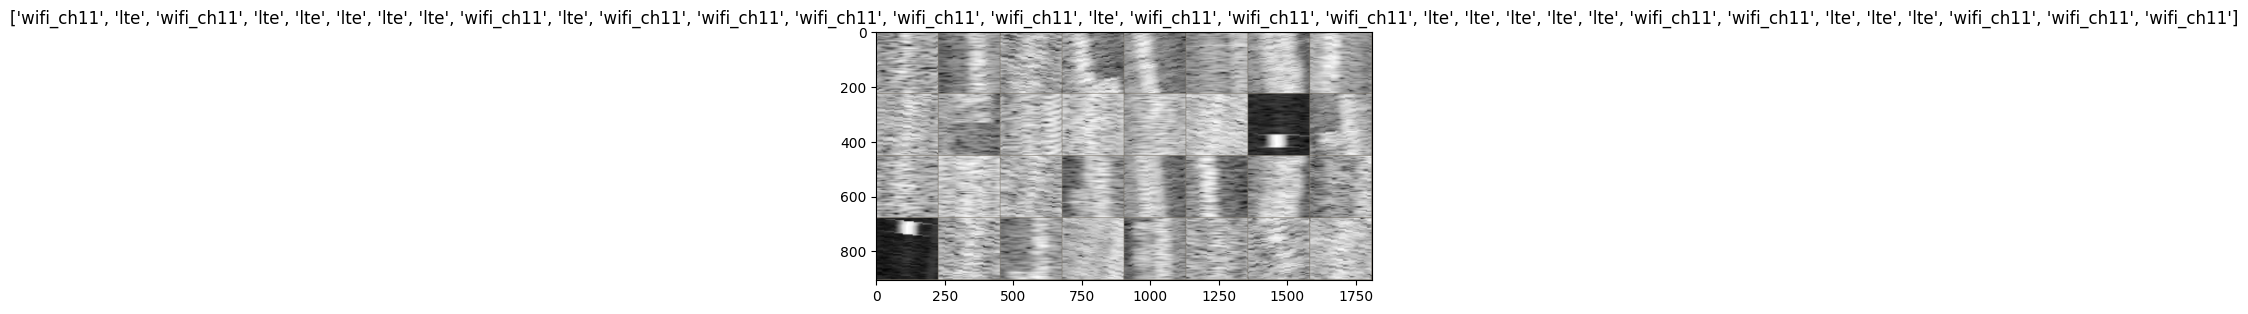

In [7]:
def imshow(inp, title = None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  
  if title is not None:
    plt.title(title)
  plt.pause(0.001)
  
inputs, classes = next(iter(val_loader))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

GPU para el enternamiento, verifico que se utilize CUDA
0-> para el primer gpu
1-> para seleccionar el segundo GPU en caso se tuviera

In [8]:
torch.cuda.set_device(0) 
device = ('cuda' if torch.cuda.is_available() else 'cpu')

print("Se entrenara con:", device)

Se entrenara con: cuda


Arquitectura de la red

In [9]:
class Network(nn.Module):
  def __init__(self):
    super(Network, self).__init__()
    self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
    self.conv2 = nn.Conv2d(10, 256, kernel_size=3)    
    self.bn1 = nn.BatchNorm2d(256)    
    self.conv3 = nn.Conv2d(256, 512, kernel_size=3)
    #512 de la capa previa, 26 tamaño de la imagen
    self.fc1 = nn.Linear(512*26*26,50)  #Una capa full conected, 50 es el numero de neuronas q quiero 
    self.fc2 = nn.Linear(50,2) #son  clases
    
  def forward(self, x):
    x = F.max_pool2d(F.relu(self.conv1(x)), 2)  #2 el tamaño de la ventana de pooling
    #x = F.max_pool2d(F.relu(self.conv2(x)), 2)
    x = F.max_pool2d(F.relu(self.bn1(self.conv2(x))), 2)
    x = F.max_pool2d(F.relu(self.conv3(x)), 2)
    #x = F.relu(self.conv3(x)
    #x = x.view(-1,30*5*5) #al valor de x le hago un, -1 desdoblo las dimensiones a un size de 320
    x = x.view(-1, self.num_flat_features(x))
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return F.log_softmax(x)
  
  def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features 

network = Network()

In [10]:
model = network.to(device)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

Función de entrenamiento para train y val

Se añade comentarios tomados de la documentación y foros explicando el proceso y parámetros utilizados

In [12]:
# Funcion para el entrenamiento
#%%time
# keeping-track-of-losses 
train_losses = []
valid_losses = []

for epoch in range(1, num_epocas + 1):
    # keep-track-of-training-and-validation-loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # training-the-model
    model.train()
    for data, target in train_loader:
        # move-tensors-to-GPU 
        data = data.to(device)
        target = target.to(device)
        
        # clear-the-gradients-of-all-optimized-variables
        optimizer.zero_grad()
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
        output = model(data)
        # calculate-the-batch-loss
        loss = criterion(output, target)
        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
        loss.backward()
        # perform-a-ingle-optimization-step (parameter-update)
        optimizer.step()
        # update-training-loss
        train_loss += loss.item() * data.size(0)
        
    # validate-the-model
    model.eval()
    for data, target in val_loader:
        
        data = data.to(device)
        target = target.to(device)
        
        output = model(data)
        
        loss = criterion(output, target)
        
        # update-average-validation-loss 
        valid_loss += loss.item() * data.size(0)
    
    # calculate-average-losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(val_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # print-training/validation-statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

/tmp/ipykernel_7686/3888295182.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Epoch: 1 	Training Loss: 1.361933 	Validation Loss: 1.091234
Epoch: 2 	Training Loss: 0.314070 	Validation Loss: 1.783272
Epoch: 3 	Training Loss: 0.271514 	Validation Loss: 1.492076
Epoch: 4 	Training Loss: 0.267765 	Validation Loss: 1.225740
Epoch: 5 	Training Loss: 0.256744 	Validation Loss: 0.864064
Epoch: 6 	Training Loss: 0.241941 	Validation Loss: 1.708785
Epoch: 7 	Training Loss: 0.251341 	Validation Loss: 1.680060
Epoch: 8 	Training Loss: 0.233928 	Validation Loss: 1.927609
Epoch: 9 	Training Loss: 0.222840 	Validation Loss: 1.310328
Epoch: 10 	Training Loss: 0.244634 	Validation Loss: 1.394812
Epoch: 11 	Training Loss: 0.230686 	Validation Loss: 1.335948
Epoch: 12 	Training Loss: 0.229063 	Validation Loss: 1.716992
Epoch: 13 	Training Loss: 0.222327 	Validation Loss: 2.545312
Epoch: 14 	Training Loss: 0.210736 	Validation Loss: 1.260193
Epoch: 15 	Training Loss: 0.207460 	Validation Loss: 1.998343
Epoch: 16 	Training Loss: 0.207576 	Validation Loss: 0.915233
Epoch: 17 	Traini

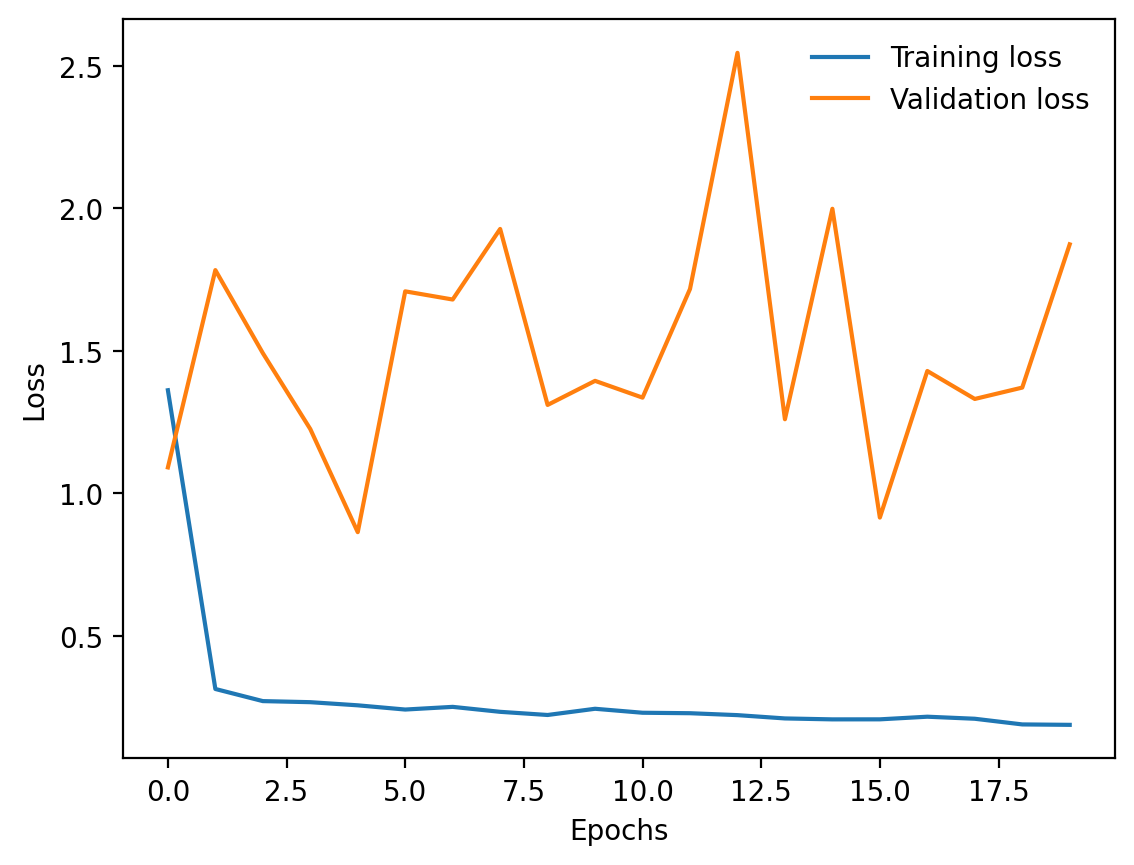

In [13]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

Funcion test

In [14]:
# test-the-model
model.eval()  # it-disables-dropout
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model: {} %'.format(100 * correct / total))

# Save 
torch.save(model.state_dict(), 'model.ckpt')

/tmp/ipykernel_7686/3888295182.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Test Accuracy of the model: 85.15625 %


Visualizar el resultado, se utiliza imagenes en test

In [15]:
def visualize_model(model, num_images):
    was_training = model.training
    
    model.eval()
    images_so_far = 0
    
    #fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
                    
            for j in range(inputs.size()[0]):
                images_so_far +=1
                ax = plt.subplot(num_images, 1, images_so_far)
                
                ax.axis('off')
                ax.set_title('Predicted: {} (Clase: {})'.format(class_names[preds[j]], class_names[labels[j]]))
                                
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return           
                
        model.train(mode = was_training)


/tmp/ipykernel_7686/3888295182.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


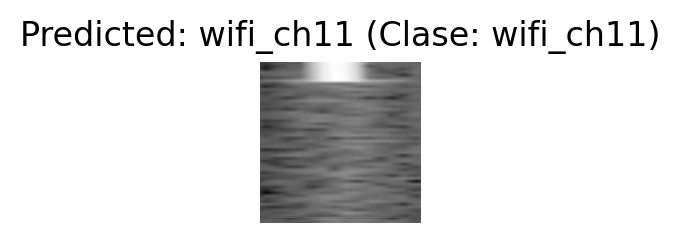

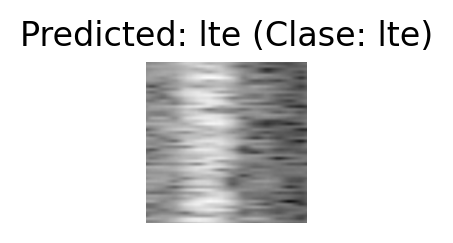

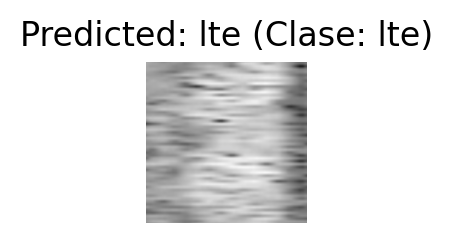

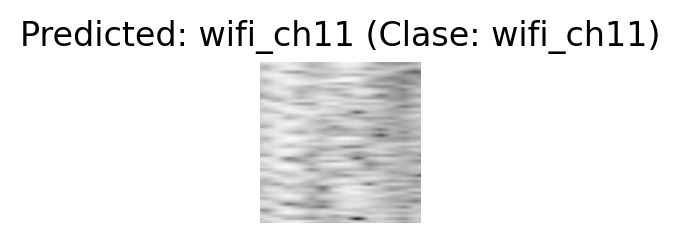

In [16]:
visualize_model(model=model, num_images = 4)